In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import (
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    pipeline, DataCollatorForSeq2Seq, EarlyStoppingCallback
)
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from safetensors.torch import load_file

2025-07-18 19:38:12.044989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752867492.234756      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752867492.292344      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read the CSV file
data = pd.read_csv("/kaggle/input/final-eng-naga/raw_data (1).csv")
extra_data=pd.read_csv("/kaggle/input/final-eng-naga/Nagamese Khobor  Comic - Sheet1.csv")

In [3]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [4]:
source_texts = list(data["English"])  
target_texts = list(data["Nagamese"]) 



# Split the data into training and validation sets
train_source_texts, val_source_texts, train_target_texts, val_target_texts = train_test_split(
    source_texts, target_texts, test_size=0.20, random_state=40
)


In [5]:
import random
random.seed(7)
# Combine and shuffle the training data
combined_train = list(zip(train_source_texts, train_target_texts))
random.shuffle(combined_train)

# Unzip back into separate lists
train_source_texts, train_target_texts = zip(*combined_train)
train_source_texts = list(train_source_texts)
train_target_texts = list(train_target_texts)

In [6]:
from datasets import Dataset

# Tokenize function
def tokenize_function(examples):
    model_inputs = tokenizer(examples["source_texts"], return_tensors="pt",max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(examples["target_texts"], return_tensors="pt",max_length=128, truncation=True, padding="max_length")["input_ids"]
    # labels = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in labels]
    model_inputs["labels"]=labels
    return model_inputs

# Convert lists to Hugging Face Dataset
train_dataset = Dataset.from_dict({"source_texts": train_source_texts, "target_texts": train_target_texts})
val_dataset = Dataset.from_dict({"source_texts": val_source_texts, "target_texts": val_target_texts})

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["source_texts", "target_texts"])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=["source_texts", "target_texts"])



Map:   0%|          | 0/6360 [00:00<?, ? examples/s]

Map:   0%|          | 0/1590 [00:00<?, ? examples/s]

In [7]:
print(train_dataset["input_ids"][0])
print(train_dataset["input_ids"][1])

print(train_dataset["labels"][0])
print(train_dataset["labels"][1])

[256047, 13710, 4062, 2294, 37124, 25026, 4990, 4414, 214566, 28120, 1733, 540, 25026, 4990, 4414, 66027, 248079, 57832, 248079, 238, 248152, 5251, 349, 28449, 1874, 3808, 5884, 4062, 1910, 6382, 239, 248079, 5057, 349, 38199, 452, 7197, 202, 349, 163766, 248075, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[256047, 1808, 180241, 202, 796, 248079, 69, 13525, 4990, 4062, 9560, 55974, 95804, 5057, 1259, 22730, 248075, 248108, 3140, 4414, 81465, 57758, 796, 248075, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2560

In [8]:
!pip install sacrebleu
import sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 31.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.9 MB/s eta 0:00:00


In [9]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode tokenized outputs into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # SacreBLEU expects reference translations as a **list of lists**
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    ter = sacrebleu.corpus_ter(decoded_preds, [decoded_labels])
    chrf = sacrebleu.corpus_chrf(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score,"ter":ter.score,"chrf":chrf.score}

In [10]:
# Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    logging_strategy="epoch", 
    eval_strategy="epoch", 
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    seed = 40,
    save_total_limit=2,
    num_train_epochs=10,
    predict_with_generate=True,
    optim="adafactor", 
    report_to=[],
    fp16=True,
    logging_dir="./logs",
    overwrite_output_dir=True,
    load_best_model_at_end=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)],
    compute_metrics=compute_metrics,
)

# Start Training
trainer.train()


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu,Ter,Chrf
1,6.548400,1.478395,4.476279,172.032244,28.631616
2,0.811900,0.603326,16.981190,79.164372,47.840436
3,0.566300,0.528088,20.967371,69.401192,51.955412
4,0.485500,0.500944,22.161199,64.930156,53.071577
5,0.435000,0.485877,23.279547,63.558304,54.464881
6,0.399900,0.477797,23.846870,63.343013,55.039387
7,0.374700,0.473103,24.024629,62.804786,54.983605
8,0.355800,0.475574,24.245177,61.823462,55.479924


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=3184, training_loss=1.2471819642800182, metrics={'train_runtime': 6857.6693, 'train_samples_per_second': 9.274, 'train_steps_per_second': 0.58, 'total_flos': 1.378278526943232e+16, 'train_loss': 1.2471819642800182, 'epoch': 8.0})

In [11]:
model.save_pretrained("./nllb_model")
tokenizer.save_pretrained("./nllb_model")

('./nllb_model/tokenizer_config.json',
 './nllb_model/special_tokens_map.json',
 './nllb_model/sentencepiece.bpe.model',
 './nllb_model/added_tokens.json',
 './nllb_model/tokenizer.json')

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

Using device: cuda


In [13]:
source_texts = val_source_texts
reference_texts = val_target_texts

In [14]:
# Translate source texts using the model
model.eval()
machine_translations = []
batch_size=32
for i in range(0, len(source_texts), batch_size):
    batch_texts = source_texts[i : i + batch_size]  # Slice batch
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    
    with torch.no_grad():
        outputs = model.generate(**inputs)
    
    batch_translations = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    machine_translations.extend(batch_translations)

In [15]:
wrapped_reference_texts = [reference_texts] 
bleu = sacrebleu.corpus_bleu(machine_translations, wrapped_reference_texts)
print("BLEU Score:", bleu.score)
ter = sacrebleu.corpus_ter(machine_translations, wrapped_reference_texts)
print("TER Score:", ter.score)
chrf = sacrebleu.corpus_chrf(machine_translations, wrapped_reference_texts)
print("CHRF Score:", chrf.score)

BLEU Score: 22.60078991224693
TER Score: 63.91378360787062
CHRF Score: 54.41210022089575


In [16]:
n = 31
inputs = tokenizer(source_texts[n], return_tensors="pt", max_length=128, truncation=True).to(device)

# Generate output token IDs
with torch.no_grad():
    generated = model.generate(**inputs, max_length=128)
    translated_text = tokenizer.decode(generated[0], skip_special_tokens=True)

print(f"Input: {source_texts[n]}")
print(f"Translated: {translated_text}")
print(f"Reference: {reference_texts[n]}")

Input: Then if you are Christ's, you are Abraham's descendants, and heirs according to promise.
Translated: Itu karone jodi apni Khrista laga ase koile, apni Abraham laga khandan ase, aru kosom diya nisena, Tai laga dhun sompoti te bi apni khan thakibo.
Reference: Kintu jodi apni Khrista laga ase, titia hoile apni Abraham laga pidhi ase, aru kosom di kena thaka laga waris khan ase.


In [17]:
n = 81
inputs = tokenizer(source_texts[n], return_tensors="pt", max_length=128, truncation=True).to(device)

# Generate output token IDs
with torch.no_grad():
    generated = model.generate(**inputs, max_length=128)
    translated_text = tokenizer.decode(generated[0], skip_special_tokens=True)

print(f"Input: {source_texts[n]}")
print(f"Translated: {translated_text}")
print(f"Reference: {reference_texts[n]}")

Input: I am writing to you, children, because your sins are forgiven because of his name.
Translated: Moi tumi khan ke likhi ase, bacha khan, kilemane Tai laga naam pora tumi khan laga paap khan maph hoise.
Reference: Moi tumi khan ke likhi ase, morom laga bacha khan, kilemane Tai laga naam pora tumi khan laga paap khan maph paise.


In [18]:
n = 22
inputs = tokenizer(source_texts[n], return_tensors="pt", max_length=128, truncation=True).to(device)

# Generate output token IDs
with torch.no_grad():
    generated = model.generate(**inputs, max_length=128)
    translated_text = tokenizer.decode(generated[0], skip_special_tokens=True)

print(f"Input: {source_texts[n]}")
print(f"Translated: {translated_text}")
print(f"Reference: {reference_texts[n]}")

Input: He who believes and is baptized will be saved, and he who does not believe will be condemned.
Translated: Jun biswas kori kena baptizma lobole, tai bachi jabo, kintu jun biswas nakore tai ke bisar koribo.
Reference: Jun manu biswas kore aru baptizma lobo, taikhan bachibo kintu jun biswas nokoribo taike nosto kori dibo.


M2M100Model is using M2M100SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` . Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Input: Beloved, if God so loved us, we also should love one another.
Translated: Morom laga bhai khan, jodi Isor pora amikhan ke eneka morom korise koile, amikhan bi ekjon-ekjon ke morom koribo lage.
Reference: Morom laga bhai khan, jodi Isor pora amikhan ke iman morom korise, titia hoile amikhan bi ekjon-ekjon ke morom koribole lage.


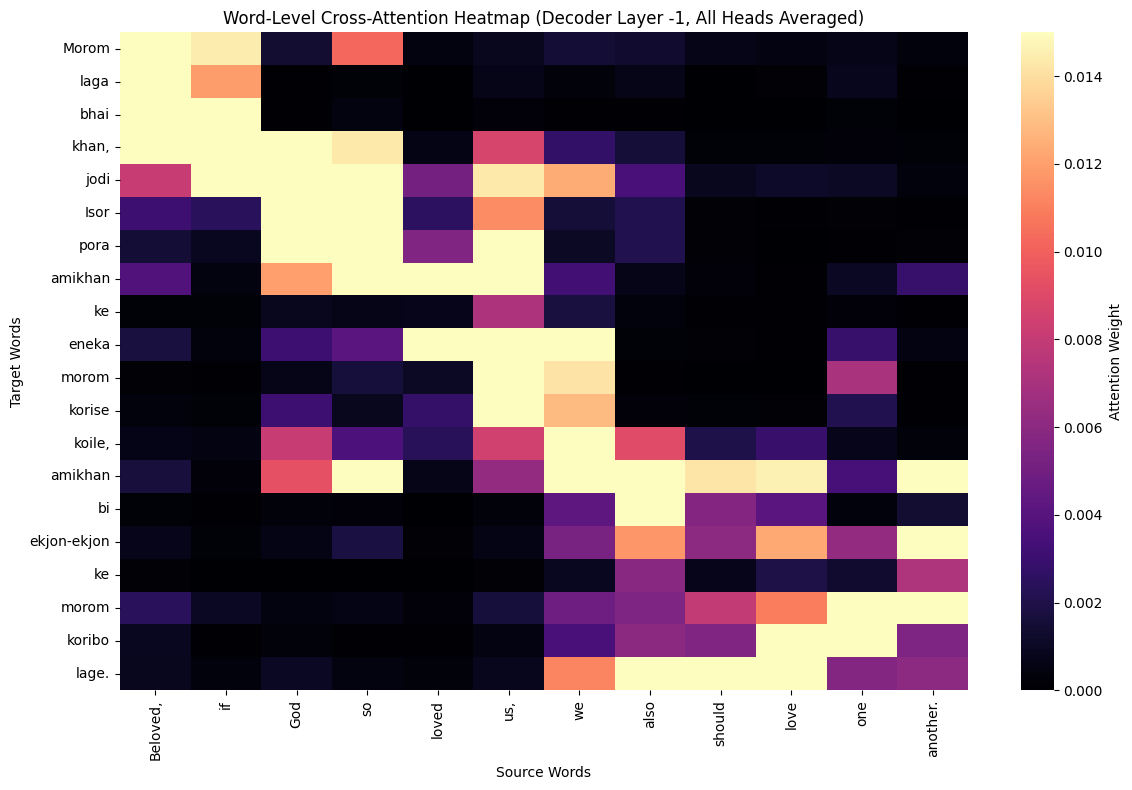


🔗 Word Alignments (English → Nagamese):

Nagamese Word   →  English Word
-----------------------------------
Morom           →  Beloved,
laga            →  Beloved,
bhai            →  if
khan,           →  if
jodi            →  God
Isor            →  so
pora            →  so
amikhan         →  us,
ke              →  us,
eneka           →  us,
morom           →  us,
korise          →  us,
koile,          →  we
amikhan         →  also
bi              →  also
ekjon-ekjon     →  another.
ke              →  another.
morom           →  one
koribo          →  love
lage.           →  love


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def merge_sentencepiece_tokens(tokens):
    words = []
    current_word = ""
    mapping = []
    word_idx = -1

    for i, tok in enumerate(tokens):
        if tok.startswith("▁") or tok.startswith("_"):  # SentencePiece or underscore-prefix
            if current_word:
                words.append(current_word)
            current_word = tok[1:]  # remove prefix
            word_idx += 1
        else:
            current_word += tok
        mapping.append(word_idx)
    if current_word:
        words.append(current_word)
    return words, mapping

def aggregate_attention(attn_matrix, src_map, tgt_map):
    num_tgt_words = max(tgt_map) + 1
    num_src_words = max(src_map) + 1
    agg_matrix = np.zeros((num_tgt_words, num_src_words))
    count_matrix = np.zeros((num_tgt_words, num_src_words))

    for i_tgt, tgt_word_idx in enumerate(tgt_map):
        for i_src, src_word_idx in enumerate(src_map):
            agg_matrix[tgt_word_idx][src_word_idx] += attn_matrix[i_tgt][i_src]
            count_matrix[tgt_word_idx][src_word_idx] += 1

    # Avoid division by zero
    count_matrix[count_matrix == 0] = 1
    return agg_matrix / count_matrix

# ----------------------------
# Your original pipeline
# ----------------------------
n = 28
inputs = tokenizer(source_texts[n], return_tensors="pt", max_length=128, truncation=True).to(device)

with torch.no_grad():
    generated = model.generate(**inputs, max_length=128)
    translated_text = tokenizer.decode(generated[0], skip_special_tokens=True)

print(f"Input: {source_texts[n]}")
print(f"Translated: {translated_text}")
print(f"Reference: {reference_texts[n]}")

decoder_input_ids = generated[:, :-1]

with torch.no_grad():
    out = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        decoder_input_ids=decoder_input_ids,
        output_attentions=True,
        return_dict=True
    )

cross_attn_all_heads = out.cross_attentions[-1][0]
cross_attn_avg = cross_attn_all_heads.mean(dim=0)  # shape: [tgt_len, src_len]

# ----------------------------
# Convert tokens to words + mapping
# ----------------------------
src_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0], skip_special_tokens=True)
tgt_tokens = tokenizer.convert_ids_to_tokens(decoder_input_ids[0], skip_special_tokens=True)

src_words, src_map = merge_sentencepiece_tokens(src_tokens)
tgt_words, tgt_map = merge_sentencepiece_tokens(tgt_tokens)

# ----------------------------
# Aggregate attention
# ----------------------------
attn_np = cross_attn_avg[:len(tgt_tokens), :len(src_tokens)].cpu().numpy()
word_attn = aggregate_attention(attn_np, src_map, tgt_map)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(word_attn, 
            xticklabels=src_words, 
            yticklabels=tgt_words,
            cmap="magma", 
            vmin=0, vmax=0.015,
            cbar_kws={"label": "Attention Weight"})
plt.title("Word-Level Cross-Attention Heatmap (Decoder Layer -1, All Heads Averaged)")
plt.xlabel("Source Words")
plt.ylabel("Target Words")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# ----------------------------
# Print Word-to-Word Alignments
# ----------------------------
print("\n🔗 Word Alignments (English → Nagamese):\n")
print(f"{'Nagamese Word':<15} →  English Word")
print("-" * 35)

for tgt_idx, tgt_word in enumerate(tgt_words):
    src_idx = np.argmax(word_attn[tgt_idx])
    print(f"{tgt_word:<15} →  {src_words[src_idx]}")

